In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chronos import ChronosPipeline
from nixtlats import NixtlaClient
from neuralforecast.models import MLP, NBEATS
from neuralforecast.losses.pytorch import HuberLoss
from neuralforecast.core import NeuralForecast
from IPython.display import clear_output
from tqdm import tqdm
import pickle

# Definindo as sementes para garantir a reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

import sys

# Add the 'src/utils' directory to the module search path
sys.path.append('../src/utils')

from nextools import *  # Module from 'src/utils' directory

In [10]:
# load dataframes from source
raw_train_df = pd.read_csv('../data/processed/train_df_praticagem.csv')
raw_test_df  = pd.read_csv('../data/processed/test_df_praticagem.csv')

crop_target_datetime = '2021-01-01 00:00:00'
target_pivot = raw_train_df.loc[raw_train_df.ds == crop_target_datetime,
                                'ds'].index.values[0]

raw_series = np.concatenate([raw_train_df[target_pivot:].y.values,
                             raw_test_df.y.values], axis=None)

raw_ssh = np.concatenate([raw_train_df[target_pivot:].ssh.values,
                          raw_test_df.ssh.values], axis=None)

raw_at = np.concatenate([raw_train_df[target_pivot:]['at'].values,
                         raw_test_df['at'].values], axis=None)

raw_ds = np.concatenate([raw_train_df[target_pivot:].ds.values,
                         raw_test_df.ds.values], axis=None)

In [11]:
# Parameters
context_window_len = 168  # len of input sequence
forecast_len = 24
batch_size = 32
epochs = 500
lr = 0.001
beta = 0.5  # Weight between hard and soft targets

In [12]:
# Load files from timeGPT time series forecast
with open('../data/interim/forecast_cache_fcst_y_df_validated_20240513_212354.pkl', 'rb') as f:
    timegpt_fcst_y_df = pickle.load(f)

with open('../data/interim/forecast_cache_fcst_y_validated_20240513_212354.pkl', 'rb') as f:
    y_timegpt = np.array(pickle.load(f))

with open('../data/interim/chronos_forecast_cache_20240514_055420.pkl', 'rb') as f:
    y_chronos = np.array(pickle.load(f))
y_chronos = y_chronos.reshape((y_chronos.shape[0],y_chronos.shape[2]))


## Create input and output sequences
X, y = create_input_output_sequences(raw_series,
                                    context_window_len,
                                    forecast_len)

## Create input and output date sequences
X_ds, y_ds = create_input_output_sequences(raw_ds,
                                    context_window_len,
                                    forecast_len)

## Create input and output date sequences
X_ssh, y_ssh = create_input_output_sequences(raw_ssh,
                                    context_window_len,
                                    forecast_len)

## Create input and output date sequences
X_at, y_at = create_input_output_sequences(raw_at,
                                    context_window_len,
                                    forecast_len)

## Split data between train and test
# idx to split first y_test ds = first ds from 
# test_df

## Compute mean for teacher features:
## y_teacher = np.mean([y_timegpt, y_chronos], axis=0)
y_teacher = y_chronos

split_idx = raw_train_df.shape[0] - target_pivot -\
    (context_window_len + forecast_len - 1)

X_train,         X_test         = X[:split_idx],         X[split_idx:]
y_train,         y_test         = y[:split_idx],         y[split_idx:]

X_train_ds,      X_test_ds      = X_ds[:split_idx],      X_ds[split_idx:]
y_train_ds,      y_test_ds      = y_ds[:split_idx],      y_ds[split_idx:]

X_train_ssh,     X_test_ssh     = X_ssh[:split_idx],     X_ssh[split_idx:]
y_train_ssh,     y_test_ssh     = y_ssh[:split_idx],     y_ssh[split_idx:]

X_train_at,      X_test_at      = X_at[:split_idx],      X_at[split_idx:]
y_train_at,      y_test_at      = y_at[:split_idx],      y_at[split_idx:]

# Teacher features (foundation models prediction)
y_train_timegpt, y_test_timegpt = y_timegpt[:split_idx], y_timegpt[split_idx:]
y_train_chronos, y_test_chronos = y_chronos[:split_idx], y_chronos[split_idx:]
y_train_teacher, y_test_teacher = y_teacher[:split_idx], y_teacher[split_idx:]

# Converter para tensores PyTorch e float32
X_train_tensor = torch.from_numpy(X_train).unsqueeze(-1).float()
y_train_tensor = torch.from_numpy(y_train).float()
y_train_teacher_tensor = torch.from_numpy(y_train_teacher).float() #distillation

X_test_tensor  = torch.from_numpy(X_test).unsqueeze(-1).float()
y_test_tensor  = torch.from_numpy(y_test).float()
y_test_teacher_tensor = torch.from_numpy(y_test_teacher).float() #distillation

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_train_teacher_tensor = y_train_teacher_tensor.to(device)

X_test_tensor  = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
y_test_teacher_tensor = y_test_teacher_tensor.to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor,
                              y_train_tensor,
                              y_train_teacher_tensor
                              )

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

In [13]:
endg = {
    'ds': X_ds,
    'y': X,
    'ssh': X_ssh,
    'at': X_at
    }

exog = {
    'ds': y_ds,
    'at': y_at
    }

 19%|█▉        | 1640/8569 [00:00<00:00, 16395.56it/s]

100%|██████████| 8569/8569 [00:00<00:00, 19913.22it/s]


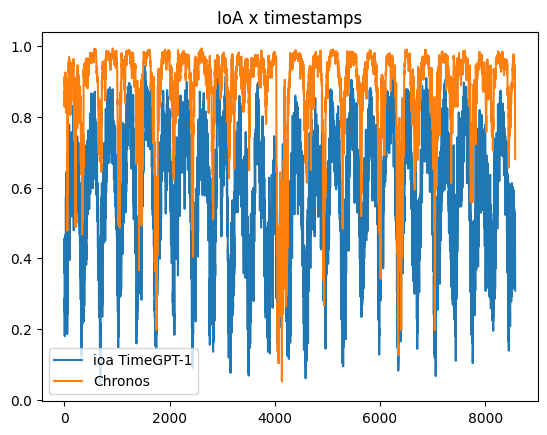

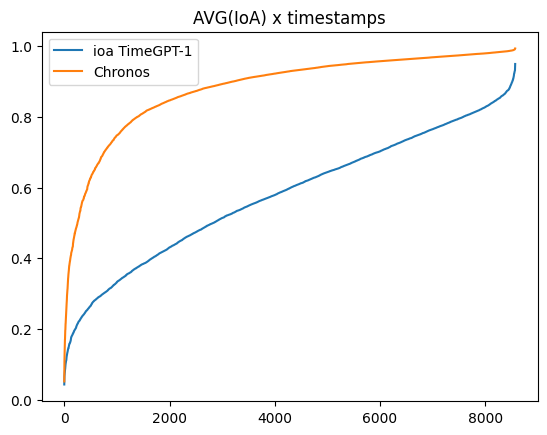

In [14]:
list_ioa_timegpt = []
list_ioa_chronos = []

list_ioa_timegpt = [calculate_ioa(y[i], fcst_y[i]) for i in tqdm(range(len(y)))]
list_ioa_chronos = [calculate_ioa(y[i], chronos_fcst_y[i][0]) for i in tqdm(range(len(y)))]

plt.plot(list_ioa_timegpt,label='ioa TimeGPT-1')
plt.plot(list_ioa_chronos,label='Chronos')
plt.legend()
plt.title('IoA x timestamps')
plt.show()

plt.plot(np.sort(list_ioa_timegpt),label='ioa TimeGPT-1')
plt.plot(np.sort(list_ioa_chronos),label='Chronos')
plt.legend()
plt.title('AVG(IoA) x timestamps')
plt.show()

In [40]:
# Define student model (smaller model)
class StudentModel(nn.Module):
    """
    Student Model class for sequence prediction.

    Attributes:
        input_size (int): Size of the input features.
        hidden_size (int): Size of the hidden state in the LSTM layer.
        output_size (int): Size of the output.

    Methods:
        forward(x): Forward pass of the model.
        init_hidden(batch_size): Initialize hidden state of the LSTM.
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize StudentModel.

        Args:
            input_size (int): Size of the input features.
            hidden_size (int): Size of the hidden state in the LSTM layer.
            output_size (int): Size of the output.
        """
        super(StudentModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]  # Get the output from the last timestep
        output = self.fc(lstm_out)
        return output

    def init_hidden(self, batch_size):
        """
        Initialize hidden state of the LSTM.

        Args:
            batch_size (int): Size of the batch.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple containing hidden states.
        """
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))

# Instantiate student model (smaller model)
student_model = StudentModel(input_size=1,
                            hidden_size=64,
                            output_size=forecast_len).to(device)

# Define loss function and optimizer for student model
criterion_student = nn.MSELoss()
optimizer_student = optim.Adam(student_model.parameters(), lr=lr)

# Lists to store losses
# teacher_losses = []
student_losses = []

# Train student model using outputs from teacher model (Knowledge Distillation)
student_model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_y, batch_y_teacher in train_loader:
        optimizer_student.zero_grad()
        # Get teacher model outputs
        # with torch.no_grad():
        #     teacher_outputs = teacher_model(batch_x)
        # Forward pass through student model
        student_outputs = student_model(batch_x)
        # Calculate loss using outputs from both models
        # loss_student = beta * criterion_student(student_outputs, batch_y)
        # loss_teacher = (1 - beta) * criterion_teacher(student_outputs, teacher_outputs)
        # loss = loss_student + loss_teacher
        loss = criterion_student(student_outputs, batch_y)
        loss.backward()
        optimizer_student.step()
        total_loss += loss.item()
    student_losses.append(total_loss / len(train_loader))
    print(f"Student Epoch {epoch + 1} | Distillation Loss: {student_losses[-1]}")

Student Epoch 1 | Distillation Loss: 0.07387621431364177
Student Epoch 2 | Distillation Loss: 0.04034051770544322
Student Epoch 3 | Distillation Loss: 0.03846548362977087
Student Epoch 4 | Distillation Loss: 0.037032738580542096
Student Epoch 5 | Distillation Loss: 0.03485214831254913
Student Epoch 6 | Distillation Loss: 0.030682624228256572
Student Epoch 7 | Distillation Loss: 0.02757576827780675
Student Epoch 8 | Distillation Loss: 0.026425684407605964
Student Epoch 9 | Distillation Loss: 0.025681142121721796
Student Epoch 10 | Distillation Loss: 0.02502730867620242
Student Epoch 11 | Distillation Loss: 0.024635585088093402
Student Epoch 12 | Distillation Loss: 0.024137093564548063
Student Epoch 13 | Distillation Loss: 0.02341045857023048
Student Epoch 14 | Distillation Loss: 0.022745822819402326
Student Epoch 15 | Distillation Loss: 0.022052691754816615
Student Epoch 16 | Distillation Loss: 0.021388408270175175
Student Epoch 17 | Distillation Loss: 0.020930422559422623
Student Epoch

In [41]:
# Define student model (smaller model)
class DistillationStudentModel(nn.Module):
    """
    Student Model class for sequence prediction.

    Attributes:
        input_size (int): Size of the input features.
        hidden_size (int): Size of the hidden state in the LSTM layer.
        output_size (int): Size of the output.

    Methods:
        forward(x): Forward pass of the model.
        init_hidden(batch_size): Initialize hidden state of the LSTM.
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize DistillationStudentModel.

        Args:
            input_size (int): Size of the input features.
            hidden_size (int): Size of the hidden state in the LSTM layer.
            output_size (int): Size of the output.
        """
        super(DistillationStudentModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]  # Get the output from the last timestep
        output = self.fc(lstm_out)
        return output

    def init_hidden(self, batch_size):
        """
        Initialize hidden state of the LSTM.

        Args:
            batch_size (int): Size of the batch.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple containing hidden states.
        """
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))

# Instantiate student model (smaller model)
distil_student_model = DistillationStudentModel(input_size=1,
                                         hidden_size=64,
                                         output_size=forecast_len).to(device)

# Define loss function and optimizer for student model
distil_criterion_student = nn.MSELoss()
distil_optimizer_student = optim.Adam(distil_student_model.parameters(), lr=lr)

# Define loss function and optimizer for student model
distil_criterion_teacher = nn.MSELoss()
distil_optimizer_teacher = optim.Adam(distil_student_model.parameters(), lr=lr)

# Lists to store losses
distil_losses = []

# Train student model using outputs from teacher model (Knowledge Distillation)
distil_student_model.train()
for epoch in range(epochs):
    total_distil_loss = 0
    for batch_x, batch_y, batch_y_teacher in train_loader:
        distil_optimizer_student.zero_grad()
        # Forward pass through student model
        distil_student_outputs = distil_student_model(batch_x)
        # Calculate loss using outputs from both models
        distil_loss_student = beta * distil_criterion_student(distil_student_outputs, batch_y)
        distil_loss_teacher = (1 - beta) * distil_criterion_teacher(distil_student_outputs, batch_y_teacher)
        distil_loss = distil_loss_student + distil_loss_teacher
        #loss = criterion_student(student_outputs, batch_y)
        distil_loss.backward()
        distil_optimizer_student.step()

        total_distil_loss += distil_loss.item()
        
    distil_losses.append(total_distil_loss / len(train_loader))

    print(f"Student Epoch {epoch + 1} | Distillation Loss: {distil_losses[-1]}")

Student Epoch 1 | Distillation Loss: 0.06482606587436913
Student Epoch 2 | Distillation Loss: 0.03347556243550643
Student Epoch 3 | Distillation Loss: 0.03167178195580251
Student Epoch 4 | Distillation Loss: 0.0305004636046745
Student Epoch 5 | Distillation Loss: 0.029167727593564043
Student Epoch 6 | Distillation Loss: 0.026456169973490602
Student Epoch 7 | Distillation Loss: 0.02346752062018982
Student Epoch 8 | Distillation Loss: 0.022168674685145166
Student Epoch 9 | Distillation Loss: 0.021401280042646968
Student Epoch 10 | Distillation Loss: 0.02079237859675103
Student Epoch 11 | Distillation Loss: 0.020506703068560127
Student Epoch 12 | Distillation Loss: 0.019976079411341646
Student Epoch 13 | Distillation Loss: 0.019673299912552712
Student Epoch 14 | Distillation Loss: 0.019456289450790587
Student Epoch 15 | Distillation Loss: 0.01894559683856991
Student Epoch 16 | Distillation Loss: 0.01864464247420346
Student Epoch 17 | Distillation Loss: 0.01831188647465854
Student Epoch 18

Student Epoch 27 | Distillation Loss: 0.01619421449189974
Student Epoch 28 | Distillation Loss: 0.016150123934329904
Student Epoch 29 | Distillation Loss: 0.015960387048958722
Student Epoch 30 | Distillation Loss: 0.0159614156184476
Student Epoch 31 | Distillation Loss: 0.015860631835704807
Student Epoch 32 | Distillation Loss: 0.015715051810704383
Student Epoch 33 | Distillation Loss: 0.015703003648352826
Student Epoch 34 | Distillation Loss: 0.015680059296010577
Student Epoch 35 | Distillation Loss: 0.015541667718503434
Student Epoch 36 | Distillation Loss: 0.01546709802485792
Student Epoch 37 | Distillation Loss: 0.015415264951265127
Student Epoch 38 | Distillation Loss: 0.015299939571506223
Student Epoch 39 | Distillation Loss: 0.01527908687495579
Student Epoch 40 | Distillation Loss: 0.015256989452630113
Student Epoch 41 | Distillation Loss: 0.015161427979667982
Student Epoch 42 | Distillation Loss: 0.015145713663370596
Student Epoch 43 | Distillation Loss: 0.015025044907158041
St

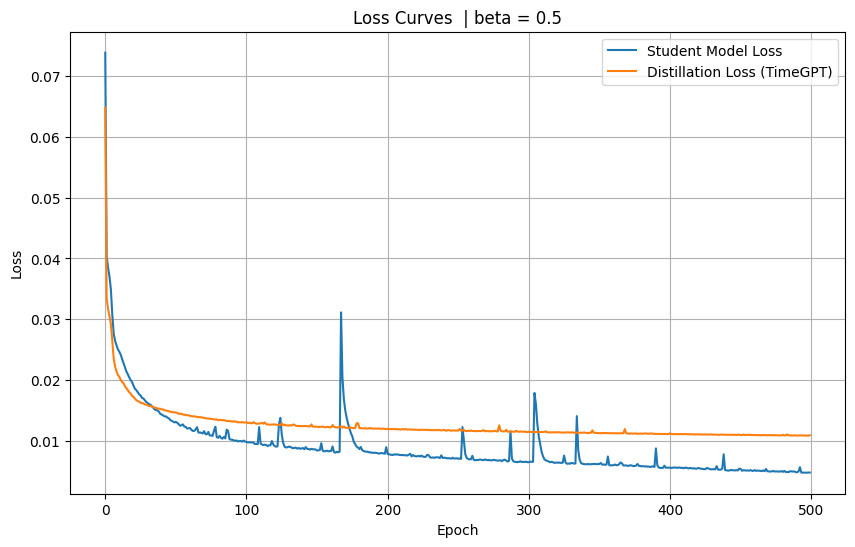

In [42]:
# Plot loss curves for teacher and student models
plt.figure(figsize=(10, 6))
#plt.plot(teacher_losses, label='Teacher Model Loss')
plt.plot(student_losses, label='Student Model Loss')
plt.plot(distil_losses, label='Distillation Loss (TimeGPT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves  | beta = 0.5')
plt.legend()
plt.grid(True)
plt.show()



Plot from train evaluation

Distillation


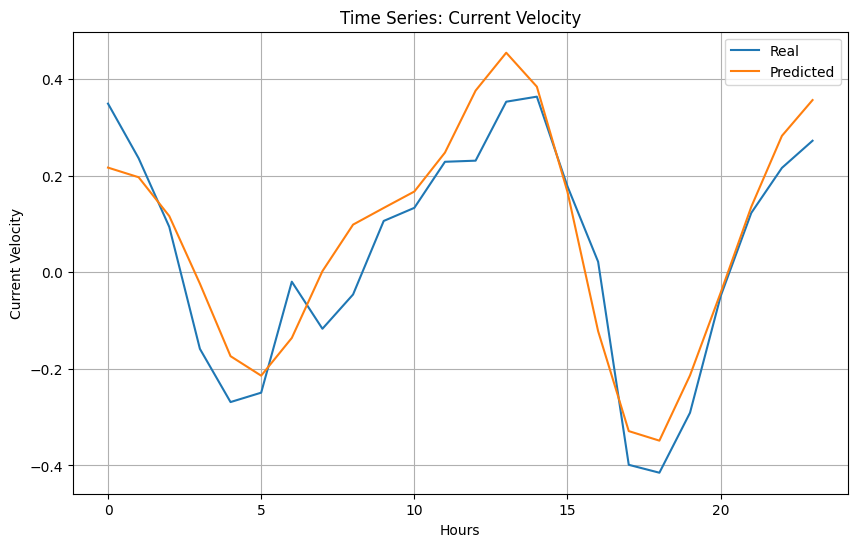


Student


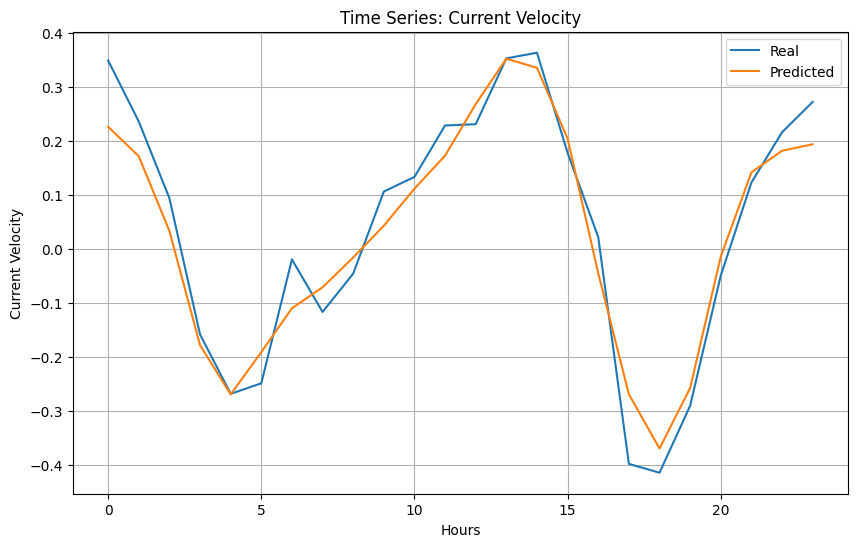

Student Model Index of Agreement (IoA): 0.9920975668625978
Distillation Student Model Index of Agreement (IoA): 0.977868140221294


In [43]:
student_model.eval()
with torch.no_grad():
    student_train_predictions = student_model(X_train_tensor).cpu().numpy()

# Calculate IoA for teacher and student models
# ioa_train_teacher = calculate_ioa(y_train, teacher_train_predictions)
ioa_train_student = calculate_ioa(y_train, student_train_predictions)

distil_student_model.eval()
with torch.no_grad():
    distil_student_train_predictions = distil_student_model(X_train_tensor).cpu().numpy()

# Calculate IoA for teacher and student models
# ioa_train_teacher = calculate_ioa(y_train, teacher_train_predictions)
distil_ioa_train_student = calculate_ioa(y_train, distil_student_train_predictions)

print('\n\nPlot from train evaluation\n')
print('Distillation')
plot_time_series(y_train[0], distil_student_train_predictions[0])
print('\nStudent')
plot_time_series(y_train[0], student_train_predictions[0])

# print("Teacher Model Index of Agreement (IoA):", ioa_train_teacher)
print("Student Model Index of Agreement (IoA):", ioa_train_student)
print("Distillation Student Model Index of Agreement (IoA):", distil_ioa_train_student)



Plot from test evaluation

Distillation
Distillation Student Model Index of Agreement (IoA): 0.9762144922551051


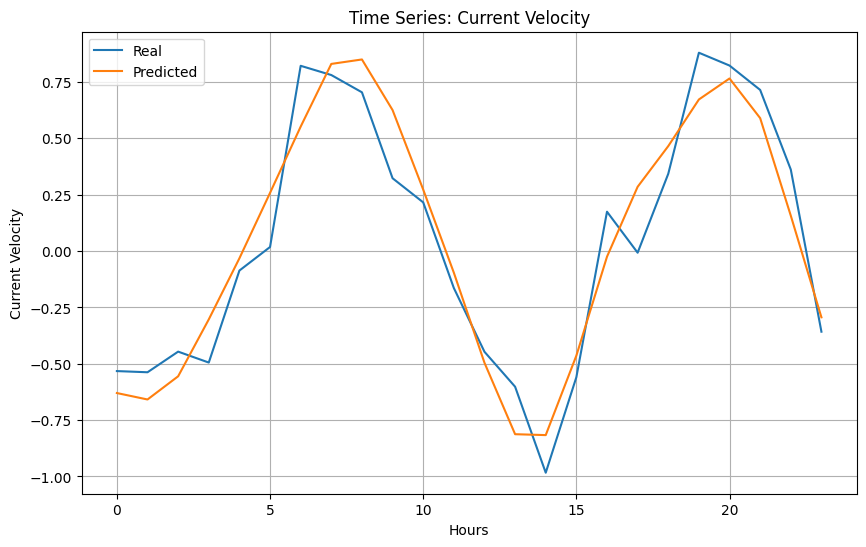


Student
Student Model Index of Agreement (IoA): 0.9678442247083884


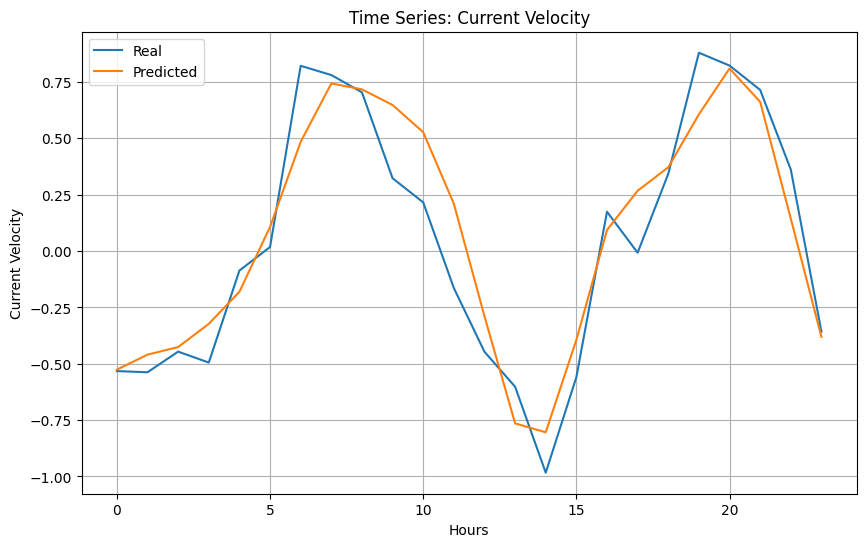

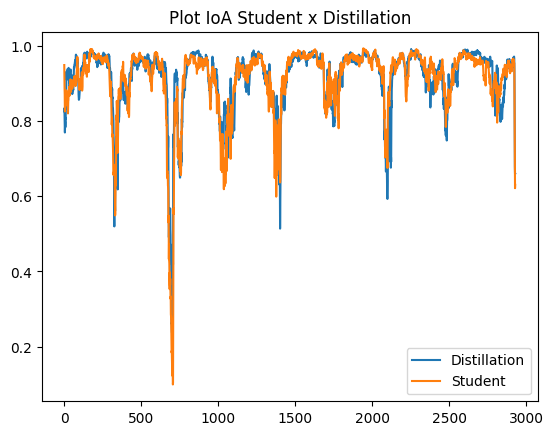

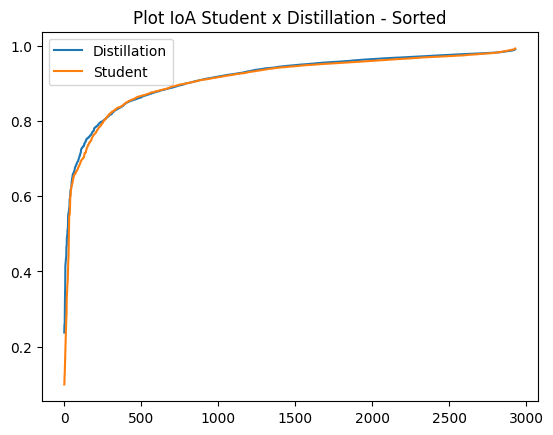

In [44]:
#### test eval

student_model.eval()
with torch.no_grad():
    student_test_predictions = student_model(X_test_tensor).cpu().numpy()

# Calculate IoA for teacher and student models
# ioa_train_teacher = calculate_ioa(y_train, teacher_train_predictions)
ioa_test_student = calculate_ioa(y_test, student_test_predictions)

distil_student_model.eval()
with torch.no_grad():
    distil_student_test_predictions = distil_student_model(X_test_tensor).cpu().numpy()

# Calculate IoA for teacher and student models
# ioa_train_teacher = calculate_ioa(y_train, teacher_train_predictions)
distil_ioa_test_student = calculate_ioa(y_test, distil_student_test_predictions)

print('\n\nPlot from test evaluation\n')
print('Distillation')
print("Distillation Student Model Index of Agreement (IoA):", calculate_ioa(y_test[200], distil_student_test_predictions[200]))
plot_time_series(y_test[200], distil_student_test_predictions[200])
print('\nStudent')
print("Student Model Index of Agreement (IoA):", calculate_ioa(y_test[200], student_test_predictions[200]))
plot_time_series(y_test[200], student_test_predictions[200])


list_ioa_test_student = []
list_distil_ioa_test_student = []


for i in range(len(y_test)):
    list_ioa_test_student.append(calculate_ioa(y_test[i], student_test_predictions[i]))
    list_distil_ioa_test_student.append(calculate_ioa(y_test[i], distil_student_test_predictions[i]))

print('\n\n')


plt.title('Plot IoA Student x Distillation')
plt.plot(list_distil_ioa_test_student, label='Distillation')
plt.plot(list_ioa_test_student, label='Student')
plt.legend()
plt.show()

print('\n\n')

plt.title('Plot IoA Student x Distillation - Sorted')
plt.plot(np.sort(list_distil_ioa_test_student), label='Distillation')
plt.plot(np.sort(list_ioa_test_student), label='Student')
plt.legend()
plt.show()



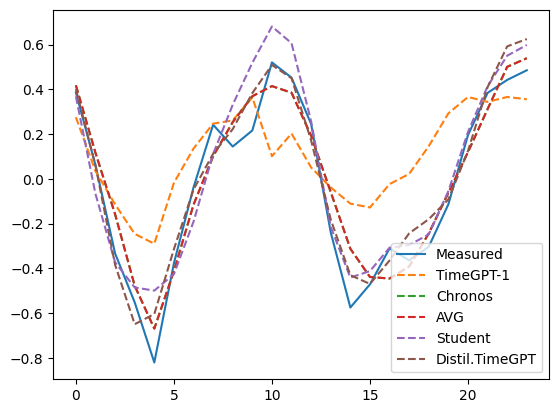

IoA TimeGPT-1:      0.7709096910396116
IoA Chronos:        0.9776356643434307
IoA AVG:            0.9776356643434307
IoA Student:        0.9721665882801931
IoA Distil.TimeGPT: 0.983949352692681


In [47]:
idx_plot = 2620

plt.plot(y_test[idx_plot],label='Measured')
plt.plot(y_test_timegpt[idx_plot],'--',label='TimeGPT-1')
plt.plot(y_test_chronos[idx_plot],'--',label='Chronos')
plt.plot(y_test_teacher[idx_plot],'--',label='AVG')
plt.plot(student_test_predictions[idx_plot],'--',label='Student')
plt.plot(distil_student_test_predictions[idx_plot],'--',label='Distil.TimeGPT')


plt.legend()
plt.show()

print(f'IoA TimeGPT-1:      {calculate_ioa(y_test[idx_plot], y_test_timegpt[idx_plot])}')
print(f'IoA Chronos:        {calculate_ioa(y_test[idx_plot], y_test_chronos[idx_plot])}')
print(f'IoA AVG:            {calculate_ioa(y_test[idx_plot], y_test_teacher[idx_plot])}')
print(f'IoA Student:        {calculate_ioa(y_test[idx_plot], student_test_predictions[idx_plot])}')
print(f'IoA Distil.TimeGPT: {calculate_ioa(y_test[idx_plot], distil_student_test_predictions[idx_plot])}')